## Goal: How many unique transcripts do we add for each additional sample? 
* also split by all and novel
* somewhere should color / order by population?  ideally would see jumps @ each pop transition
* also should order by total uniq

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [23]:
p_c_dict, p_order = get_population_colors()

## First -- all transcripts

In [10]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
print(len(df.index))
temp = df.copy(deep=True)
# temp = df.loc[(df.structural_category!='full-splice_match')&\
#               (df.structural_category!='incomplete-splice_match')]
print(len(temp.index))

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')

temp2 = temp[['cell_line_id', 'n_ic']]

12993951
12993951


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4078/442663657.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [11]:
temp2.head()

,cell_line_id,n_ic
0,HG01567,51334
1,HG03732,44634
2,HG03732,44634
3,HG03732,44634
4,HG01567,51334


In [12]:
temp2 = temp2.sort_values(by='n_ic', ascending=False)
temp2.drop_duplicates(inplace=True)
order = temp2.cell_line_id.tolist()
temp.drop(['hap1', 'hap2', 'hg38', 'n_ic'], axis=1, inplace=True)

temp['detected'] = True
temp = temp.pivot(index='ic_id', columns='cell_line_id')
temp.columns.name = None
temp.columns = temp.columns.get_level_values(1)
temp.fillna(False, inplace=True)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_4078/1554135618.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [36]:
temp = temp[order]
prev_ics = []
big_df = pd.DataFrame()
for i, c in enumerate(temp.columns):
    temp2 = temp.loc[temp[c]==True]
    pop = meta_df.loc[meta_df.cell_line_id_1000g==c, 'population'].values[0]
    ics = temp2.index.tolist()
    n = len(list(set(ics)-set(prev_ics)))
    prev_ics += ics
    # print(len(prev_ics))
    temp3 = pd.DataFrame(data=[[n,i,pop]], columns=['n_added_uniq', 'n_samples', 'population'])
    big_df = pd.concat([big_df, temp3], axis=0)

In [38]:
# init_plot_settings(aspect='rectangle')
# ax = sns.lineplot(data=big_df,
#              x="n_samples",
#              y="n_added_uniq", marker="o")
# ax.set(xlabel='Samples (ranked by IC discovery)', 
#        ylabel='# unique ICs added by sample')
# plt.axhline(y=big_df.n_added_uniq.min(), color="k",
#             linestyle="--", linewidth=1.5, label=f"y = {big_df.n_added_uniq.min()}")
# print(big_df.n_added_uniq.min())

In [72]:
min_row

n_added_uniq            1081
n_samples                 29
population               ITU
min_label       Min. = 1,081
Name: 0, dtype: object

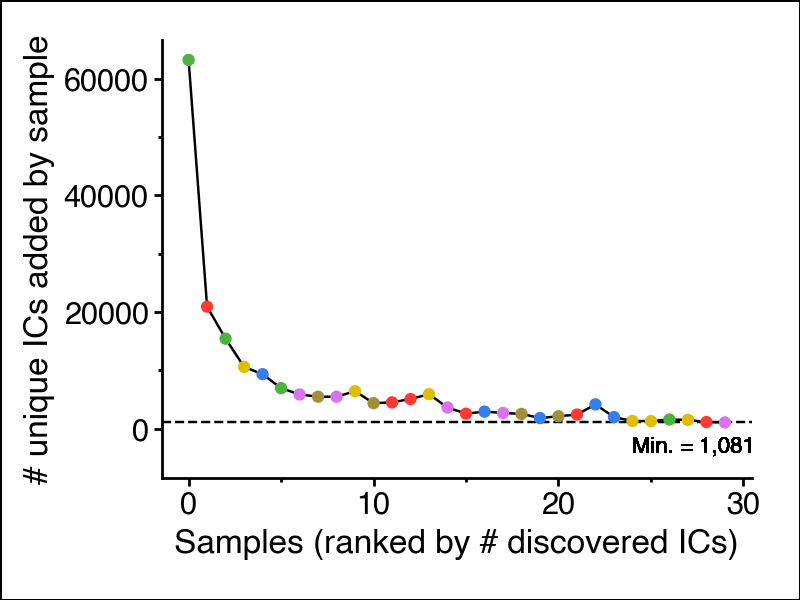

In [101]:
min_val = big_df.n_added_uniq.min()
min_row = big_df[big_df.n_added_uniq == min_val].iloc[0]  # just one row for label
big_df['min_label'] = 'Min. = '+f'{min_val:,}'

(
    ggplot(big_df, aes(x='n_samples', y='n_added_uniq'))
    + geom_hline(
        yintercept=big_df.n_added_uniq.min(),
        linetype='dashed',
        color='black',
        size=0.5
    )
    + geom_line()
    + geom_point(aes(color='population'))
    + scale_color_manual(values=p_c_dict)
    + labs(
        x='Samples (ranked by # discovered ICs)',
        y='# unique ICs added by sample'
    )
    + geom_text(
        aes(x=min_row.n_samples, y=min_row.n_added_uniq, label='min_label'),
        ha='left', va='bottom',
        nudge_x=-5, nudge_y=-6000,
        size=8,
        inherit_aes=False
    )
    + my_theme(w=4, h=3)
    + theme(legend_position='none')
    + ylim(0-5000, big_df['n_added_uniq'].max())
)
